In [77]:
import json
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

In [83]:
class MatrixFactorization():
  def __init__(self, train_matrix, test_matrix, latent, epoch):
    self.train_matrix = train_matrix
    self.test_matrix = test_matrix
    self.num_users, self.num_items = train_matrix.shape
    self.latent = latent
    self.epoch = epoch
    
  def prediction(self, user_index, item_index):
    return self.bias + self.u_bias[user_index] + self.i_bias[item_index] + self.user_matrix[user_index, :].dot(self.item_matrix[item_index, :].T)

  def cost(self, matrix):
    xs, ys = matrix.nonzero()
    predicted = self.bias + self.u_bias[:, np.newaxis] + self.i_bias[np.newaxis:, ] + self.user_matrix.dot(self.item_matrix.T)
    error = 0

    for x, y in zip(xs, ys):
      error = error + pow(matrix[x][y] - predicted[x][y] , 2)
    return np.sqrt(error) /len(xs)

  def train(self):
    self.user_matrix = np.random.normal(scale=1./self.latent, size = (self.num_users, self.latent))
    self.item_matrix = np.random.normal(scale=1./self.latent, size = (self.num_items, self.latent))

    self.u_bias = np.zeros(self.num_users)
    self.i_bias = np.zeros(self.num_items)
    self.bias = np.mean(self.train_matrix[np.where(self.train_matrix != 0)])

    self.training_process = []
    for epoch_ in range(self.epoch):
      for i in range(self.num_users):
        for j in range(self.num_items):
          if self.train_matrix[i][j] > 0:
            prediction = self.prediction(i, j)
            err = self.train_matrix[i][j] - prediction

            self.u_bias[i] = self.u_bias[i] + 0.01*(err - 0.01 * self.u_bias[i])
            self.i_bias[j] = self.i_bias[j] + 0.01*(err - 0.01 * self.i_bias[j])

            latent_user = (err * self.item_matrix[j, :]) - (0.01 * self.user_matrix[i, :])
            latent_item = (err * self.user_matrix[i, :]) - (0.01 * self.item_matrix[j, :])

            self.user_matrix[i, :] = self.user_matrix[i, :] + 0.01 * latent_user
            self.item_matrix[j, :] = self.item_matrix[j, :] + 0.01 * latent_item
      
      cost = self.cost(self.train_matrix)
      self.training_process.append(cost)
      #print("Epoch : %d ; cost = %.4f" %(epoch_ + 1, cost))
    return self.training_process
  
  def test(self):
    for i in range(self.num_users):
      for j in range(self.num_items):
        if self.test_matrix[i][j] > 0:
          cost = self.cost(self.test_matrix)
    print("Test Result: error = %.4f" % (cost))
    return cost




In [84]:
json_data = []
with open("./yelp_academic_dataset_review.json", 'r', encoding='utf-8-sig') as f:
  for i, line in tqdm(enumerate(f)):
    json_data.append(json.loads(line))

1125458it [00:29, 37720.08it/s]


In [85]:
df = pd.DataFrame(json_data).loc[:, ['user_id', 'business_id', 'stars']]

user_id = df['user_id'].tolist()
user_id_100 = list()
temp_user = Counter(user_id).most_common(100)
for key in temp_user:
  user_id_100.append(key[0])


business_id = df['business_id'].tolist()
business_id_50 = list()
temp_business = Counter(business_id).most_common(50)
for key in temp_business:
  business_id_50.append(key[0])







In [86]:
interac_matrix = np.zeros((100,50))

for x, a in tqdm(enumerate(user_id_100)):
  temp = df['user_id'] == a
  for y, b in enumerate(business_id_50):
    temp_ = df['business_id'] == b
    data = df[temp & temp_]
    if len(data) > 0:
      data = data.iloc[[0], [2]].values[0]
      interac_matrix[x][y] = data

100it [12:43,  7.63s/it]


In [87]:
index = 0
for i in range(100):
  count = 0
  for j in range(50):
    count = count + interac_matrix[i][j]
  if count == 0:
    index = index + 1


In [88]:
non_zero = np.count_nonzero(interac_matrix != 0)

test_count = int(non_zero * 0.2)
train_count = int(non_zero - test_count)


In [89]:
print(non_zero)
print(test_count)
print(train_count)

789
157
632


In [90]:
count_ = 0
test_matrix = np.zeros((100, 50))

while(test_count > count_):
  random_x = random.randint(0, 99)
  random_y = random.randint(0, 49)

  if interac_matrix[random_x][random_y] != 0:
    if (interac_matrix.sum(axis = 0)[random_y] == interac_matrix[random_x][random_y] or interac_matrix.sum(axis= 1)[random_x] == interac_matrix[random_x][random_y]):
      continue
    else:
      temp = interac_matrix[random_x][random_y]
      interac_matrix[random_x][random_y] = 0
      test_matrix[random_x][random_y] = temp
      count_ = count_ + 1
        

In [91]:
count_ = 0
for i in range(len(interac_matrix)):
  for j in range(len(interac_matrix[i])):
    if interac_matrix[i][j] != 0:
      count_+=1

count__ = 0
for i in range(len(test_matrix)):
  for j in range(len(test_matrix[i])):
    if test_matrix[i][j] != 0:
      count__+=1


Test Result: error = 0.1044
Test Result: error = 0.0771
Test Result: error = 0.0763
Test Result: error = 0.0730


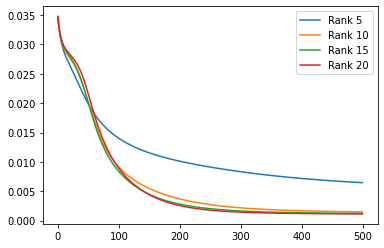

In [92]:
f1 = MatrixFactorization(interac_matrix, test_matrix, 5, 500)
f1_train = f1.train()
plt.plot(f1_train)
f1_test = f1.test()

f2 = MatrixFactorization(interac_matrix, test_matrix, 10, 500)
f2_train = f2.train()
plt.plot(f2_train)
f2_test = f2.test()

f3 = MatrixFactorization(interac_matrix, test_matrix, 15, 500)
f3_train = f3.train()
plt.plot(f3_train)
f3_test = f3.test()

f4 = MatrixFactorization(interac_matrix, test_matrix, 20, 500)
f4_train = f4.train()
plt.plot(f4_train)
f4_test = f4.test()

plt.legend(['Rank 5', 'Rank 10', 'Rank 15', 'Rank 20'], loc = 1)
plt.savefig('train_result.jpg')



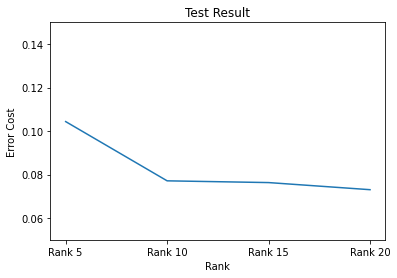

<Figure size 432x288 with 0 Axes>

In [93]:
plt.plot(['Rank 5', 'Rank 10', 'Rank 15', 'Rank 20'], [f1_test, f2_test, f3_test, f4_test])
plt.xlabel('Rank')
plt.ylabel('Error Cost')
plt.ylim([0.05, 0.15])
plt.title('Test Result')
plt.show()
plt.savefig('test_result.jpg')